In [15]:
%reset -f
%matplotlib inline

from matplotlib.pylab import *

# SCHÉMA UPWIND


## Introduction
On reconsidère le problème de transport en une dimension d'espace dans le domaine borné $[0;L]$ avec une vitesse $c$ constante non nulle et des conditions aux limites de périodicité
$$
\begin{cases}
\partial_t u(t,x) + c\partial_x u(t,x)=0	&\text{pour } (t,x)\in\ [0;T]\ \times\ [0;L],\\
u(t,x+L)=u(t,x)					&\text{pour } (t,x)\in\ [0;T]\ \times\ [0;L],\\
u(0,x)=g(x)					&\text{pour } x\in[0;L].
\end{cases}
$$
On souhaite calculer la valeur de la solution $u$ en un ensemble discret de points en espace et en temps. Plus précisément, en fixant un pas d'espace $\Delta x=L/(N-1)>0$ ($N$ entier positif) et  un pas de temps $\Delta t>0$, on cherche à calculer $u_j^n\approx u(j\Delta x,n\Delta t)$ la valeur d'une solution discrète approchée au point $(x_j,t^n)$. On sait que $u(x,t)=g(x-ct)$ est la solution exacte. Les conditions aux limites de périodicité conduisent aux égalités $u_0^n=u_{N}^n$ pour tout $n\ge0$, par conséquent l'inconnue discrète à chaque pas de temps est un vecteur $u^n=(u_j^n)_{0\le j\le N}$.

Notre stratégie consiste à remplacer des opérateurs différentiels par des quotients aux différences finies. En utilisant différentes façon d'évaluer les dérivées partielles, beaucoup de choix de schémas sont possibles. Nous voulons en étudier ici le schéma Upwind ou décentré Amont. 

Soit $\alpha:=c\frac{\Delta t}{\Delta x}$. 



## Valeurs numériques pour les tests
Dans les tests suivants on prendra
- largeur du domaine $L=8$ 
- temps final $T=24$
- $c=1$ ou $c=-1$
- $N=51$ points de discrétisation spatiale

In [16]:
L  = 8
N  = 51
xx = linspace(0,L,N)
dx = xx[1]-xx[0]

t=0
T  = 24

## Donnée initiale 
Pour tous les tests de cette étude nous considérons la donné initiale suivante:
$$
g(x)=
\begin{cases}
\dfrac{1}{2}+\dfrac{1}{2}\sin\left( \dfrac{4\pi}{L}x-\dfrac{\pi}{2} \right)&\text{ si }x\in\ \left]0;\dfrac{L}{2}\right[,\\
0 &\text{ si }x\in\ \left]\dfrac{L}{2};\dfrac{2L}{3}\right[\ \cup\ \left]\dfrac{5L}{6};L\right[,\\
1 &\text{ sinon.}
\end{cases}
$$

## Solution exacte
Par la méthode des caracthéristiques nous avons montré que la solution de ce problème est
$$
u(t,x)=g(x-ct).
$$

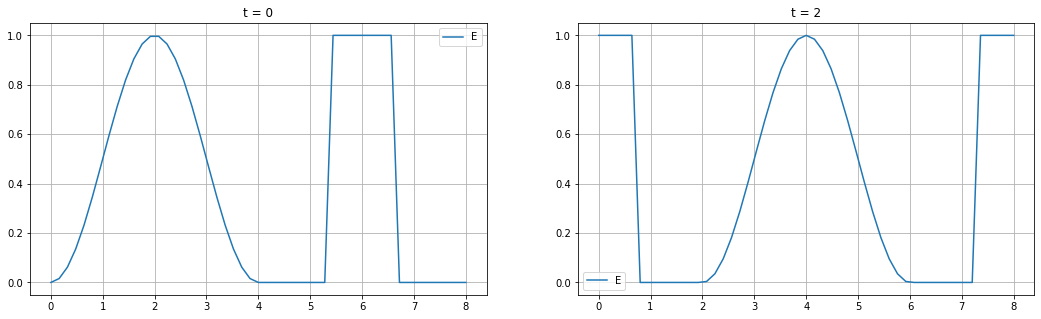

In [17]:
def g(x):
    if x<L/2:
        return 0.5+0.5*sin(4*pi*x/L-pi/2)
    elif L/2<=x<2*L/3 or 5*L/6<=x<=L:
        return 0
    else:
        return 1

def exacte(t,x):
    xi = x-c*t - floor((x-c*t)/L)*L
    return (1+sin(4*pi*xi/L-0.5*pi))*0.5*(xi<L*0.5) + 0*(xi<L*0.66 or xi>L*0.833)+1*(L*0.66<xi<L*0.833)


# Exemple avec c=1
c=1

figure(figsize=(18,5)) 
subplot(1,2,1)
plot(xx,[exacte(0,x) for x in xx])
title(f't = {0}')
legend('Exacte')
grid()
subplot(1,2,2)
plot(xx,[exacte(2,x) for x in xx])
title(f't = {2}')
legend('Exacte')
grid();


## Schéma Upwind (ou décentré amont)

Selon le signe de la célerité c, on obtient deux représentations de l'équation en difference finie: 



si $c>0$ :

$$
\frac{u_j^{n+1}-u_j^n}{\Delta t}+c\frac{(u_{j}^n-u_{j-1}^n)}{\Delta x} + O(\Delta t,\Delta x)
$$

d'où

$$
u_j^{n+1} = u_j^{n} - \frac{c\Delta t}{\Delta x}\left(u_{j}^{n}-u_{j-1}^{n}\right) + O(\Delta t^2,\Delta x)
$$

si $c<0$ :

$$
\frac{u_j^{n+1}-u_j^n}{\Delta t}+c\frac{(u_{j+1}^n-u_{j}^n)}{\Delta x} + O(\Delta t,\Delta x)
$$
d'où

$$
u_j^{n+1} = u_j^{n} - \frac{c\Delta t}{\Delta x}\left(u_{j+1}^{n}-u_{j}^{n}\right) + O(\Delta t^2,\Delta x)
$$

qu'on peut résumer en:

$$
u_j^{n+1}=u_j^n - \frac{(c+|c|)\Delta t}{2\Delta x}(u_{j}^n-u_{j-1}^n) - \frac{(c-|c|)\Delta t}{2\Delta x}(u_{j+1}^n-u_{j}^n) + O(\Delta t^2,\Delta x)
$$

et en posant $\alpha =c\frac{\Delta t}{\Delta x}$, on obtient:

$$
u_j^{n+1} = u_j^n - \frac{\alpha+|\alpha|}{2}(u_{j}^n-u_{j-1}^n) - \frac{\alpha-|\alpha|}{2}(u_{j+1}^n-u_{j}^n) $$ 

i.e:

\begin{cases} 
    u_j^{n+1} = u_j^{n} - \alpha \left(u_{j}^{n}-u_{j-1}^{n}\right) + O(\Delta t^2,\Delta x) \quad \text{si} \quad \alpha > 0 \\
    u_j^{n+1} = u_j^{n} - \alpha \left(u_{j+1}^{n}-u_{j}^{n}\right) + O(\Delta t^2,\Delta x) \quad \text{si} \quad  \alpha < 0 \end{cases}


In [18]:
def upwind(c,dt,dx,uu):
    uuNew=copy(uu)
    a = c*dt/dx
    if a>0:
        uuNew[0]=uu[-1]
        uuNew[1:]=uuNew[1:]-a*(uu[1:]-uu[0:-1])
    else:
        uuNew[:-1]=uuNew[:-1]-a*(uu[1:]-uu[:-1])
        uuNew[-1]=uu[0]
    return uuNew

In [19]:
# FONCTION POUR L'AFFICHAGE
def affichage():
    figure(figsize=(18,5)) 
    subplot(1,2,1)
    plot(xx,[exacte(0,x) for x in xx])
    plot(xx,[exacte(0,x) for x in xx],'--')
    title(f't = {0}')
    legend(['Exacte','Approchée'])
    grid()
    subplot(1,2,2)
    plot(xx,[exacte(T,x) for x in xx])
    plot(xx,uu,'--')
    title(f't = {T}')
    legend(['Exacte','Approchée'])
    grid();

## Stencil
La collection des couples $\{(j_k,n)\}$ qui interviennent dans l'équation discrète au point $(j,n+1)$ est appelé $\textit{stencil}$ du schéma (qu'on peut essayer de traduire par support). En général, plus le stencil est large, plus le schéma est coûteux et difficile à programmer.

Le calcul de la solution au point $(j,n+1)$ depends du signe de a. En effet, si a est positive alors on doit utiliser les valeurs aux points $\{(j-1,n),(j,n)\}$ et si a est négatif, les valeurs aux points $\{(j,n),(j+1,n)\}$

![alt text](dg.png)

## Étude de la stabilité

On utilise l'analyse de Fourier: pour $k$~$\in$~$\mathbb{Z}$, le coefficient de Fourier $\hat u ^n(k)$ de la solution du schéma vérifie
\begin{align*}
\hat u ^{n+1}(k)
&=
\left[1-\frac{\alpha+|\alpha|}{2}\frac{\alpha+|\alpha|}{2}(1-e^{-2  \pi i \Delta x}) - \frac{\alpha-|\alpha|}{2}(e^{2 \pi i  k \Delta x} -1) \right]
\hat u ^n(k).
\end{align*}
En notant $\xi\equiv 2\pi k \Delta x$, on a
\begin{align*}
\hat u ^{n+1}(k)
&=
\left[1-\frac{\alpha+|\alpha|}{2}\frac{\alpha+|\alpha|}{2}(1-e^{-i \xi}) - \frac{\alpha-|\alpha|}{2}(e^{i \xi} -1) \right]\hat u ^n(k)\\
&=
\left[1-|\alpha| - \alpha(e^{i \xi}-e^{-i \xi}) + |\alpha|(e^{i \xi} + e^{-i \xi}) \right]\hat u ^n(k)\\
&=
\left[1-|\alpha|-i\alpha\sin(\xi)+|\alpha|cos(\xi)\right]\hat u ^n(k).
\end{align*}
Après simplification on obtient 
$$
|\hat u ^{n+1}(k)|^2=|A(k)|^2|\hat u ^n(k)|^2
$$
avec
\begin{align*}
|A(k)|^2
&\equiv
\left[1-|\alpha|+|\alpha|\cos(\xi)\right]^2+\alpha^2\sin^2\xi=\\
&=1+2(1 - |\alpha|)(|\alpha|- \alpha\cos(\xi)).-
\end{align*}
On a
$$
|A(k)|\le1\ \forall k\in\mathbb{Z}
\ \iff\ 
2(1 - |\alpha|)(|\alpha|- \alpha\cos(\xi)) \geq 0\ \forall\xi\in\mathbb{R} \quad \text{et comme}\quad |\alpha|- \alpha\cos(\xi) \geq 0 
\ \iff\ 
2(1 - |\alpha|) \ge 0.
$$
Doc pour $|\alpha| \le 1$ on a $|A(k)|\le1$ pour toute fréquence $k$ $\in$ $\mathbb{Z}$, ce qui prouve que **le schéma est stable en norme $L^2$ sous la condition CFL $|\alpha| \le 1$.**

### Tests de stabilité

#### Test 1: cfl=1.1, c=1
Comme $\alpha>1$ le schéma est instable:

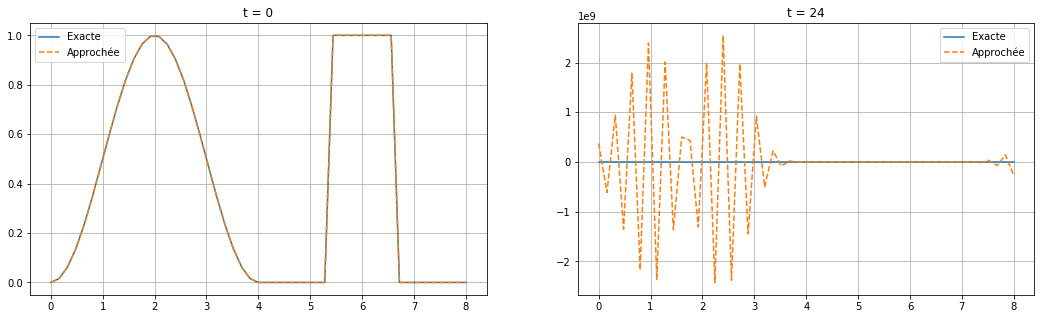

In [20]:
cfl=1.1
c=1

t=0
dt=cfl*dx
uu=array([exacte(0,x) for x in xx])
while t<=T:
    t+=dt
    uu=upwind(c,dt,dx,uu)

affichage()

#### Test 2: cfl=0.1, c=1
Comme $\alpha<1$ le schéma est stable, cependant l'erreur est très grande:

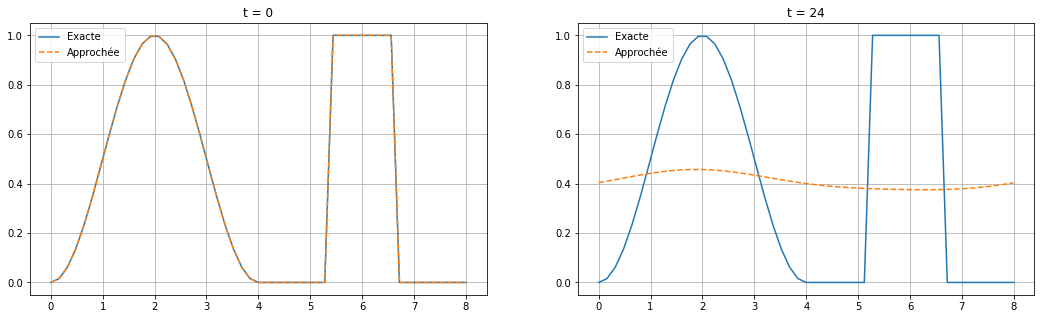

In [21]:
cfl=0.1
c=1

t=0
dt=cfl*dx/abs(c)
uu=array([exacte(0,x) for x in xx])
while t<=T:
    t+=dt
    uu=upwind(c,dt,dx,uu)

affichage()

#### Test 3: cfl=0.999, c=1
Comme $\alpha<1$ le schéma est stable et l'erreur est "optimale":

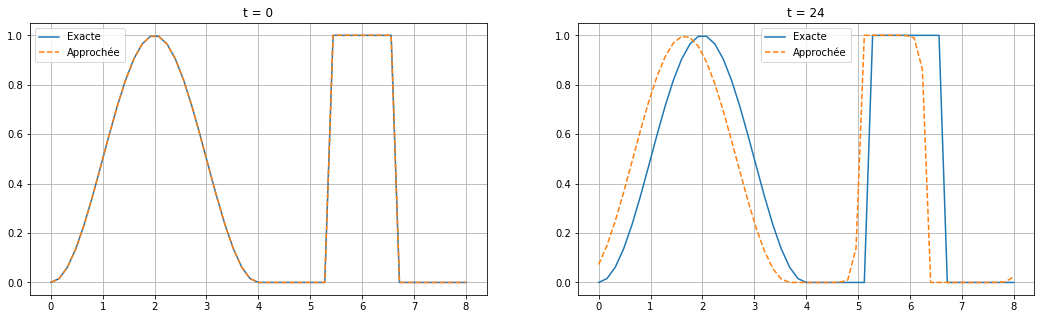

In [22]:
cfl=0.999
c=1

t=0
dt=cfl*dx/abs(c)
uu=array([exacte(0,x) for x in xx])
while t<=T:
    t+=dt
    uu=upwind(c,dt,dx,uu)

affichage()

#### Test 4: cfl=0.999, c=-1
Comme $\alpha<0$ le schéma est stable car la condition de CFL |a|<1 est satisfaite.

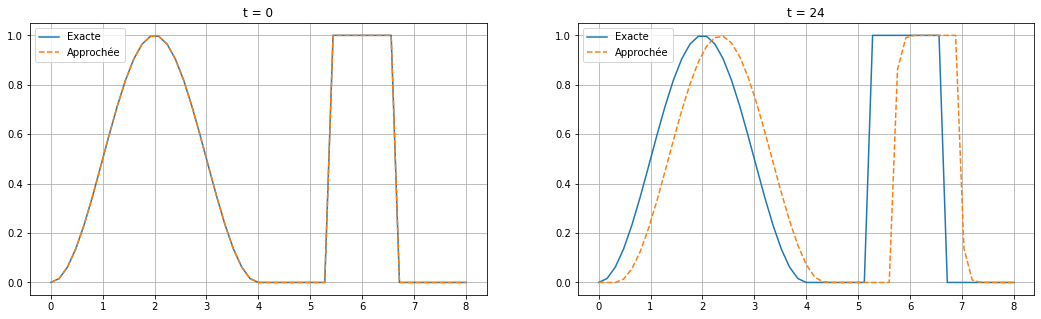

In [23]:
cfl=0.999
c=-1

t=0
dt=cfl*dx/abs(c)
uu=array([exacte(0,x) for x in xx])
while t<=T:
    t+=dt
    uu=upwind(c,dt,dx,uu)

affichage()

#### Test 1: cfl=1.1, c=-1
Comme $\alpha < -1$ le schéma est instable:

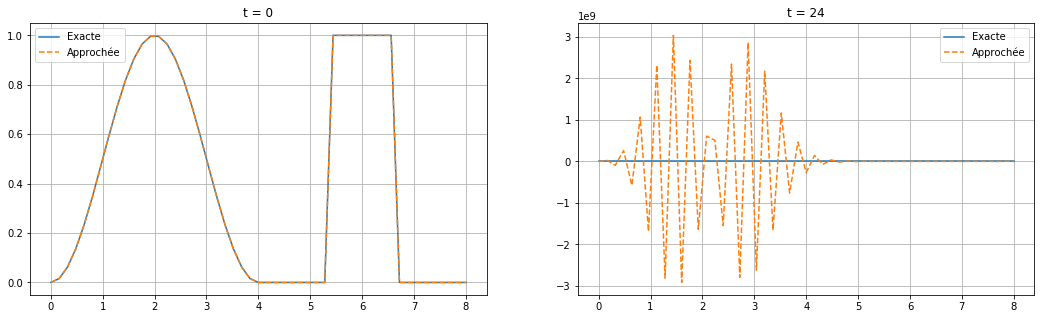

In [24]:
cfl=1.1
c=-1

t=0
dt=cfl*dx/abs(c)
uu=array([exacte(0,x) for x in xx])
while t<=T:
    t+=dt
    uu=upwind(c,dt,dx,uu)

affichage()

## Étude de l'ordre de consistance

On remplace $u_i^m$ par $u(x_i,t^m)$ où $u$ est une fonction régulière, $i=j-1,j$ et $m=n,n+1$. On définit l'erreur de troncature par
\begin{align*}
\tau_j^n
\equiv
\frac{u(x_j,t^{n+1})-u(x_j,t^n)}{\Delta t}+\left(c+|c|\right)\frac{u(x_{j},t^n)-u(x_{j-1},t^n)}{2\Delta x}+\left(c-|c|\right)\frac{u(x_{j+1},t^n)-u(x_{j},t^n)}{2\Delta x}.
\end{align*}
On fait un développement de Taylor en $x$ autour du point $x_j$ et en $t$ autour du point $t^n$ et, comme $u$ est solution de l'équation $\partial_t u = -c\partial_x u$, on a
\begin{align*}
u(x_{j-1},t^{n})
&=
u(x_j,t^n)
-
\Delta x \frac{\partial u}{\partial x}(x_j,t^n)
+
\frac{(\Delta x)^2}{2} \frac{\partial^2 u}{\partial x^2}(x_j,t^n)
+
O((\Delta x)^2),
\\
u(x_j,t^{n+1})
&=
u(x_j,t^n)
+
\Delta t \frac{\partial u}{\partial t}(x_j,t^n)
+
\frac{(\Delta t)^2}{2} \frac{\partial^2 u}{\partial t^2}(x_j,t^n)
+
O((\Delta t)^2)
\\
&=
u(x_j,t^n)
+
\Delta t \left(-c\frac{\partial u}{\partial x}(x_j,t^n)\right)
+
\frac{(\Delta t)^2}{2} \frac{\partial}{\partial t}\left(-c\frac{\partial u}{\partial x}(x_j,t^n)\right)
+
O((\Delta t)^2)
\\
&=
u(x_j,t^n)
-c
\Delta t \frac{\partial u}{\partial x}(x_j,t^n)
-c
\frac{(\Delta t)^2}{2} \frac{\partial}{\partial x}\left(\frac{\partial u}{\partial t}(x_j,t^n)\right)
+
O((\Delta t)^2)
\\
&=
u(x_j,t^n)
-
c\Delta t \frac{\partial u}{\partial x}(x_j,t^n)
+
c^2\frac{(\Delta t)^2}{2} \frac{\partial^2 u}{\partial x^2}(x_j,t^n)
+
O((\Delta t)^2)
\\
u(x_{j+1},t^{n})
&=
u(x_j,t^n)
+
\Delta x \frac{\partial u}{\partial x}(x_j,t^n)
+
\frac{(\Delta x)^2}{2} \frac{\partial^2 u}{\partial x^2}(x_j,t^n)
+
O((\Delta x)^2)
.
\end{align*}
Par conséquent l'erreur de troncature se réécrit
\begin{align*}
\tau_j^n
&\equiv
\frac{u(x_j,t^{n+1})-u(x_j,t^n)}{\Delta t}+\left(c+|c|\right)\frac{u(x_{j},t^n)-u(x_{j-1},t^n)}{2\Delta x}+\left(c-|c|\right)\frac{u(x_{j+1},t^n)-u(x_{j},t^n)}{2\Delta x}
\\
&=
\left(c^2 \frac{\Delta t}{2}-|c|\frac{\Delta x}{2}\right) \frac{\partial^2 u}{\partial x^2}(x_j,t^n)
+O((\Delta x)+(\Delta t))
\\
&=
O((\Delta x)+(\Delta t)).
\end{align*}
Le schéma est donc d'ordre $1$ en temps et en espace. 

## Étude de l'équation équivalente

On appelle équation équivalente d'un schéma l'équation obtenue en ajoutant au modèle étudié la partie principale (c'est-à-dire le terme d'ordre le plus bas) de l'erreur de troncature.  

Notre schéma est consistant. Cependant, si on ajoute à l'équation la partie principale de l'erreur de troncature, alors ce schéma non seulement est encore consistant avec cette nouvelle équation *équivalente*, mais est même strictement plus précis pour cette équation équivalente. En d'autre termes, le schéma est "plus consistants" avec l'équation équivalente qu'avec l'équation qu'on veut approcher.

Cette équation va nous donner des renseignements précieux sur le comportement numérique du schéma. Le coefficient de diffusion (c'est-à-dire le coefficient de la dérivée seconde) de l'équation équivalente est appelé diffusion numérique. S'il est grand on dit que le schéma est diffusif (ou dissipatif). Le comportement typique d'un schéma diffusif est sa tendance à étaler artificiellement les données initiales au cours du temps. Si le schéma est précis d'ordre $2$ alors l'équation équivalente ne contient pas de terme de diffusion mais un terme du troisième ordre, dit dispersif. Le comportement typique d'un schéma dispersif est qu'il produit des oscillation lorsque la solution est discontinue. En effet, le terme dispersif modifie la vitesse de propagation des modes de Fourier de la solution (particulièrement des modes de fréquence élevée), alors qu'un terme diffusif ne fait qu'atténuer son amplitude. 

Pour le schéma décentré à gauche on a 
$$
\partial_t u(t,x) + c\partial_x u(t,x) +\left(c^2 \frac{\Delta t}{2}-|c|\frac{\Delta x}{2}\right) \partial_{xx}u(t,x)=0
$$
C'est donc un schéma diffusif. 

Si $c>0$, comme $\Delta t=\text{cfl}\frac{\Delta x}{c}$ on obtient
$$
\partial_t u(t,x) + c\partial_x u(t,x) +\left(\text{cfl}-1\right)c\frac{\Delta x}{2} \partial_{xx}u(t,x)=0
$$
si $\text{cfl}\approx 1$ ce terme est petit, tandis que si $\text{cfl}\ll 1$ le terme de diffusion devient important (cf. Tests 2 et 3).

Et si $c<0$,  on obtient:
$$\partial_t u(t,x) + c\partial_x u(t,x) +\left(\text{cfl}+1\right)c\frac{\Delta x}{2} \partial_{xx}u(t,x)=0
$$

On obtient le résultat opposé i.e si $\text{cfl}\approx -1$ ce terme est petit, tandis que si $\text{cfl}\gg -1$ le terme de diffusion devient important.



### Test de l'ordre de convergence

Pour vérifier empiriquement l'ordre de convergence considérons la donnée initiale régulière suivante:
$$
g(x)=\dfrac{1}{2}+\dfrac{1}{2}\sin\left( \dfrac{4\pi}{L}x-\dfrac{\pi}{2}\right)
$$


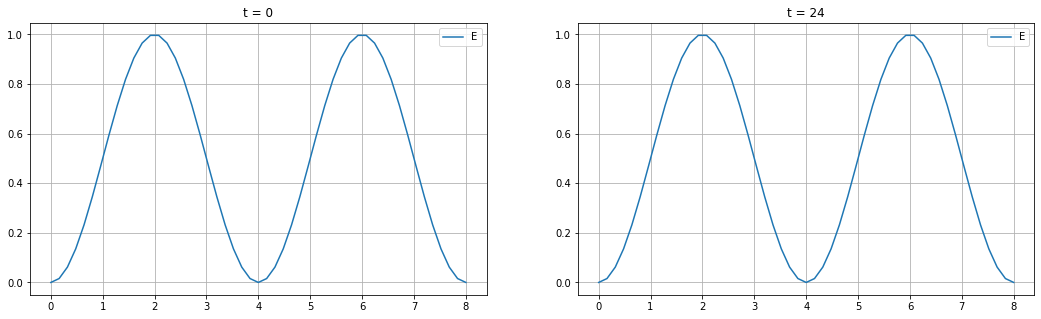

In [25]:
def g(x):
    return 0.5+0.5*sin(4*pi*x/L-pi/2)

exacte = lambda t,x : g(x-c*t)*(0<=x<=L)

figure(figsize=(18,5)) 
subplot(1,2,1)
plot(xx,[exacte(0,x) for x in xx])
title(f't = {0}')
legend('Exacte')
grid()
subplot(1,2,2)
plot(xx,[exacte(T,x) for x in xx])
title(f't = {T}')
legend('Exacte')
grid();

Pour afficher l'ordre de convergence on affiche les points (`dx[k]`,`err[k]`) en echèlle logarithmique: on représente $\ln(\Delta x)$ sur l'axe des abscisses et $\ln(\text{err})$ sur l'axe des ordonnées. Le but de cette représentation est clair: si $\text{err}=C(\Delta x)^p$ alors $\ln(\text{err})=\ln(C)+p\ln(\Delta x)$. En échelle logarithmique, $p$ représente donc la pente de la ligne droite $\ln(\text{err})$.

Pour estimer la pente globale de cette droite (par des moindres carrés) on peut utiliser la fonction `polyfit` (du module `numpy` que nous avons déjà importé avec `matplotlib.pylab`). 

Ordre=1.14


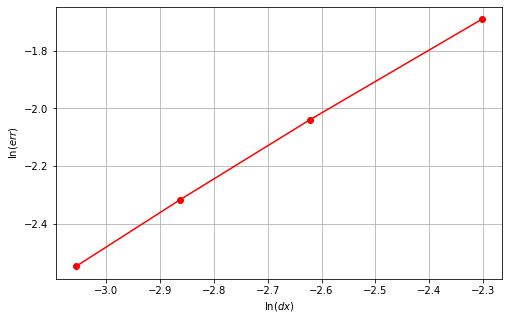

In [26]:
cfl=0.99
c=1

H = []
err = []
N = 51
for k in range(4):
    N+=30
    xx = linspace(0,L,N)
    dx = xx[1]-xx[0]
    H.append(dx)
    yy = array([exacte(0,x) for x in xx])
    t=0
    dt=cfl*dx
    uu=array([exacte(0,x) for x in xx])
    while t<=T:
        t+=dt
        uu=upwind(c,dt,dx,uu)
    err.append(max(abs(uu-yy)))
    
print ('Ordre=%1.2f' %(polyfit(log(H),log(err), 1)[0]))

figure(figsize=(8,5))
plot(log(H), log(err), 'r-o')
xlabel('$\ln(dx)$')
ylabel('$\ln(err)$')
grid(True);

Ordre=1.14


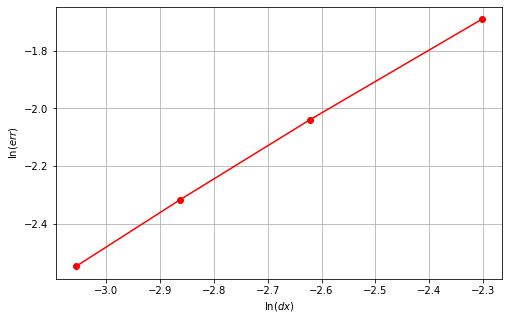

In [27]:
#Celerité négatif

cfl=0.99
c=-1

H = []
err = []
N = 51
for k in range(4):
    N+=30
    xx = linspace(0,L,N)
    dx = xx[1]-xx[0]
    H.append(dx)
    yy = array([exacte(0,x) for x in xx])
    t=0
    dt=cfl*dx
    uu=array([exacte(0,x) for x in xx])
    while t<=T:
        t+=dt
        uu=upwind(c,dt,dx,uu)
    err.append(max(abs(uu-yy)))
    
print ('Ordre=%1.2f' %(polyfit(log(H),log(err), 1)[0]))

figure(figsize=(8,5))
plot(log(H), log(err), 'r-o')
xlabel('$\ln(dx)$')
ylabel('$\ln(err)$')
grid(True);